                                                      date   open    high  \
Wed Aug 23 2023 15:15:00 GMT+0530 (India Standa...  158.00  158.0   80.95   
Thu Aug 24 2023 09:15:00 GMT+0530 (India Standa...  110.00  142.9  107.10   
Thu Aug 24 2023 09:30:00 GMT+0530 (India Standa...  139.55  160.0  129.85   
Thu Aug 24 2023 09:45:00 GMT+0530 (India Standa...  161.15  201.1  161.15   
Thu Aug 24 2023 10:00:00 GMT+0530 (India Standa...  179.50  181.2  165.35   

                                                       low  close  volume  \
Wed Aug 23 2023 15:15:00 GMT+0530 (India Standa...   80.95    196      75   
Thu Aug 24 2023 09:15:00 GMT+0530 (India Standa...  140.50  15197    9315   
Thu Aug 24 2023 09:30:00 GMT+0530 (India Standa...  160.00  20415   18840   
Thu Aug 24 2023 09:45:00 GMT+0530 (India Standa...  179.10  37530   29055   
Thu Aug 24 2023 10:00:00 GMT+0530 (India Standa...  180.45   8325   31560   

                                                    open_interest  
Wed Au

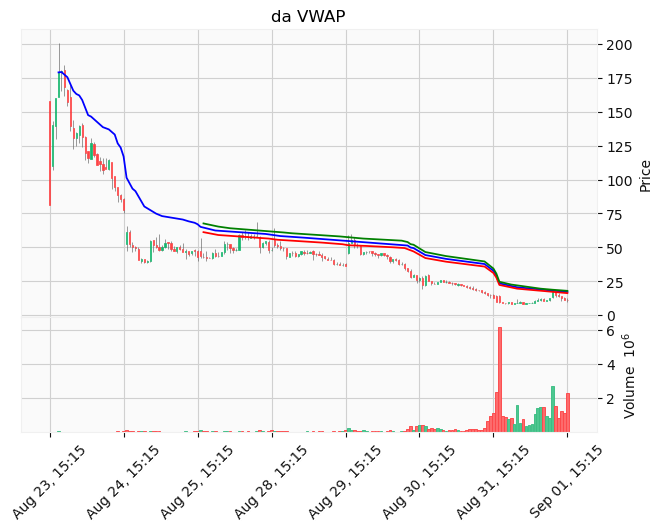

In [36]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf

cur_path = "C:\\Users\\ashis\\OneDrive\\Desktop\\Anchored_Vwap_Code\\"


# Function to parse the date string
def parse_date(date_str):
    # Split the string to extract the date part without timezone
    date_part = date_str.split(' GMT')[0]
    # Parse the date using the specified format
    return datetime.strptime(date_part, '%a %b %d %Y %H:%M:%S')


def num_days_in_dataframe(df):
    # Convert the date strings to datetime objects
    start_date_str = str(df['parsed_date'].iloc[0])
    end_date_str = str(df['parsed_date'].iloc[-1])
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    # Calculate the difference between end_date and start_date
    date_difference = end_date - start_date
    # Extract the number of days from the difference
    number_of_days = date_difference.days
    return number_of_days


def get_anchors_from_dataframe(df):
    # Find the highest value in the 'high' column
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    highest_high = df['High'].max()
    
    # Find the index (row) where the highest value occurs
    index_of_highest_high = df['High'].idxmax()
#     print(f"The highest value in the 'high' column is: {highest_high}")
#     print(f"The index of the highest value is: {index_of_highest_high}")

    return highest_high, index_of_highest_high


def fetch_data():
    df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\10 aug 46500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 5min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\7 sep 45000ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\7 sep 45500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\7 sep 46000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46000ce 15min.csv', skiprows=2)
    print(df.head())
    df.columns = ["Open", "High", "Low", "Close", "Volume","OpenInterest", "temp"]
    df.drop(["temp"], axis = 1, inplace = True)
    df['parsed_date'] = df.index.to_series().apply(parse_date)
    return df

def convert_index_to_datetime(df):
    index = [datetime.strptime(date, "%a %b %d %Y %H:%M:%S %Z%z (India Standard Time)") for date in df.index]
    df = pd.DataFrame(df.values, columns=df.columns, index=index)
    return df




def backtest_actual():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.3 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    
    print(f"len_train_data: {len(train_data)} ,,, len_test_data: {len(test_data)} ")
    
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    # Convert OHLCV values to float/int for vwap calculations
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer
    lower_range_arr = []
    upper_range_arr = []

    for idx in range(len(test_data)):
        # Test data candle -> Append to Train data 
        # Calculate Anchored Vwap for the new Train_Data
        # Check if current_candle_close is in range of AnchoredVwap
        # if it is, Buy condition 
        
        candle_data = test_data.iloc[idx]
        row_to_append_df = pd.DataFrame([candle_data], columns=train_data.columns)
        train_data = pd.concat([train_data, row_to_append_df])
        anchor_value, anchor_time = get_anchors_from_dataframe(train_data)
        anchor_timeframe = anchor_time

        anchor_vwap = train_data.loc[anchor_timeframe:]['Volume'].mul(train_data.loc[anchor_timeframe:]['Close']).cumsum() / \
                      train_data.loc[anchor_timeframe:]['Volume'].cumsum()

        x = len(train_data)
        y = len(anchor_vwap)
        nans = int(x-y)
        nan_values = pd.Series([np.nan] * nans , dtype=float)
#         extended_series = pd.concat([nan_values, anchor_vwap])
        anchor_vwap = pd.concat([nan_values, anchor_vwap])

            
        current_close_price = float(candle_data["Close"])
        current_anchor = float(anchor_vwap.iloc[-1])
        lower_range = current_anchor * 0.95
        upper_range = current_anchor * 1.05
        lower_range_arr.append(lower_range)
        upper_range_arr.append(upper_range)
#         print(f"lower_range: {lower_range} <= current_close:{current_close_price} <= upper_range: {upper_range} ")
        
#         if lower_range <= current_close_price <= upper_range:
        if lower_range <= current_close_price :
            print("Found a SELL SIGNAL")
            print("date : "+ str(candle_data["parsed_date"]))
            print("Price: "+ str(current_close_price))
        # for each candle data, check if the anchor_vwap is close to "close" of my current candle
    
    print(len(lower_range_arr))
    print(len(upper_range_arr))
    
    x = len(train_data)
    y = len(lower_range_arr)
    nans = int(x-y)
    nan_values = pd.Series([np.nan] * nans, dtype=float)
    lower_range_arr = pd.concat([nan_values, pd.Series(lower_range_arr)])
    upper_range_arr = pd.concat([nan_values, pd.Series(upper_range_arr)])
    apd = mpf.make_addplot( anchor_vwap.values, color='blue', title='Anchored VWAP')
    apd1 = mpf.make_addplot( lower_range_arr, color='red', title='asdf VWAP')
    apd2 = mpf.make_addplot( upper_range_arr, color='green', title='da VWAP')
    mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1, apd2])
    plt.show()

def backtest():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.7 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    backtest_actual()


def strategy_main():
    backtest_actual()


if __name__ == '__main__':
    strategy_main()


Number of days in the date range: 9 days
len_train_data: 52 ,,, len_test_data: 124 
Found a BUY SIGNAL
Date: 2023-08-28 12:30:00
Buy Price: 58.8
Found a SELL SIGNAL (Loss)
Date: 2023-08-29 10:15:00
Sell Price: 43.25
P&L: -15.55
Total P&L: -15.55
124
124


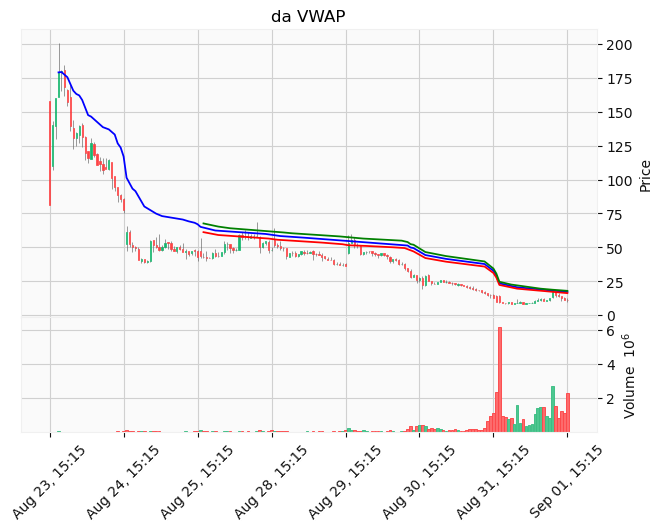

In [39]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf

cur_path = "C:\\Users\\ashis\\OneDrive\\Desktop\\Anchored_Vwap_Code\\"


# Function to parse the date string
def parse_date(date_str):
    # Split the string to extract the date part without timezone
    date_part = date_str.split(' GMT')[0]
    # Parse the date using the specified format
    return datetime.strptime(date_part, '%a %b %d %Y %H:%M:%S')


def num_days_in_dataframe(df):
    # Convert the date strings to datetime objects
    start_date_str = str(df['parsed_date'].iloc[0])
    end_date_str = str(df['parsed_date'].iloc[-1])
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    # Calculate the difference between end_date and start_date
    date_difference = end_date - start_date
    # Extract the number of days from the difference
    number_of_days = date_difference.days
    return number_of_days


def get_anchors_from_dataframe(df):
    # Find the highest value in the 'high' column
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    highest_high = df['High'].max()
    
    # Find the index (row) where the highest value occurs
    index_of_highest_high = df['High'].idxmax()
#     print(f"The highest value in the 'high' column is: {highest_high}")
#     print(f"The index of the highest value is: {index_of_highest_high}")

    return highest_high, index_of_highest_high


def fetch_data():
    df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\10 aug 46500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 5min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\7 sep 45000ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\7 sep 45500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\7 sep 46000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46000ce 15min.csv', skiprows=2)
    df.columns = ["Open", "High", "Low", "Close", "Volume","OpenInterest", "temp"]
    df.drop(["temp"], axis = 1, inplace = True)
    df['parsed_date'] = df.index.to_series().apply(parse_date)
    return df

def convert_index_to_datetime(df):
    index = [datetime.strptime(date, "%a %b %d %Y %H:%M:%S %Z%z (India Standard Time)") for date in df.index]
    df = pd.DataFrame(df.values, columns=df.columns, index=index)
    return df




def backtest_actual():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.3 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    
    print(f"len_train_data: {len(train_data)} ,,, len_test_data: {len(test_data)} ")
    
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    # Convert OHLCV values to float/int for vwap calculations
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer
    lower_range_arr = []
    upper_range_arr = []

    ####################### Code to buy / sell ################################
    position = None  # Start with no position
    buy_price = None  # Initialize buy price
    profit_threshold = 0.25  # 25% profit threshold
    loss_threshold = -0.25  # 25% loss threshold (negative value)
    total_pnl = 0  # Initialize total P&L
    amount_to_invest = 10000  # Initial investment amount
    stop_loss_percentage = 0.01  # 1% stop loss
    
    for idx in range(len(test_data)):
        # Test data candle -> Append to Train data 
        # Calculate Anchored Vwap for the new Train_Data
        # Check if current_candle_close is in range of AnchoredVwap
        # if it is, Buy condition 
        
        candle_data = test_data.iloc[idx]
        row_to_append_df = pd.DataFrame([candle_data], columns=train_data.columns)
        train_data = pd.concat([train_data, row_to_append_df])
        anchor_value, anchor_time = get_anchors_from_dataframe(train_data)
        anchor_timeframe = anchor_time

        anchor_vwap = train_data.loc[anchor_timeframe:]['Volume'].mul(train_data.loc[anchor_timeframe:]['Close']).cumsum() / \
                      train_data.loc[anchor_timeframe:]['Volume'].cumsum()

        x = len(train_data)
        y = len(anchor_vwap)
        nans = int(x-y)
        nan_values = pd.Series([np.nan] * nans , dtype=float)
#         extended_series = pd.concat([nan_values, anchor_vwap])
        anchor_vwap = pd.concat([nan_values, anchor_vwap])

            
        current_close_price = float(candle_data["Close"])
        current_anchor = float(anchor_vwap.iloc[-1])
        lower_range = current_anchor * 0.95
        upper_range = current_anchor * 1.05
        lower_range_arr.append(lower_range)
        upper_range_arr.append(upper_range)
        
#         if lower_range <= current_close_price :
#             print("Found a SELL SIGNAL")
#             print("date : "+ str(candle_data["parsed_date"]))
#             print("Price: "+ str(current_close_price))
        # for each candle data, check if the anchor_vwap is close to "close" of my current candle
        
        
        ############################ Buy / sell code conditions ###########################
        if position is None:
            # First condition is always a buy when there's no position
            if lower_range <= current_close_price:
                buy_price = current_close_price
                position = "buy"
                print("Found a BUY SIGNAL")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Buy Price: " + str(buy_price))
        elif position == "buy":
            if (current_close_price - buy_price) >= (profit_threshold * buy_price):
                # Sell when profit reaches 25%
                position = "sell"
                pnl = current_close_price - buy_price
                total_pnl += pnl
                print("Found a SELL SIGNAL (Profit)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Sell Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
            elif (current_close_price - buy_price) <= (loss_threshold * buy_price):
                # Sell when loss reaches 25%
                position = "sell"
                pnl = current_close_price - buy_price
                total_pnl += pnl
                print("Found a SELL SIGNAL (Loss)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Sell Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
            elif (total_pnl + (current_close_price - buy_price)) <= -(stop_loss_percentage * amount_to_invest):
                # Exit position completely if total loss exceeds 1% of amount_to_invest
                position = "sell"
                pnl = current_close_price - buy_price
                total_pnl += pnl
                print("Found a SELL SIGNAL (Stop Loss)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Sell Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
                print("Stop Loss Hit. Total Loss: {:.2f}".format(total_pnl))
        elif position == "sell":
            # Check for take profit
            if total_pnl >= (profit_threshold * amount_to_invest):
                position = "sell"
                pnl = current_close_price - buy_price
                total_pnl += pnl
                print("Found a SELL SIGNAL (Take Profit)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Sell Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
                print("Take Profit Hit. Total Profit: {:.2f}".format(total_pnl))

    # Ensure the last position is a sell if not already
    if position == "buy":
        position = "sell"
        pnl = current_close_price - buy_price
        total_pnl += pnl
        print("Found a SELL SIGNAL (End of Data)")
        print("Date: " + str(candle_data["parsed_date"]))
        print("Sell Price: " + str(current_close_price))
        print("P&L: {:.2f}".format(pnl))
        print("End of Data. Total P&L: {:.2f}".format(total_pnl))

    print("Total P&L: {:.2f}".format(total_pnl))
    
    ############################ Buy / sell code conditions ###########################
    
    print(len(lower_range_arr))
    print(len(upper_range_arr))
    
    x = len(train_data)
    y = len(lower_range_arr)
    nans = int(x-y)
    nan_values = pd.Series([np.nan] * nans, dtype=float)
    lower_range_arr = pd.concat([nan_values, pd.Series(lower_range_arr)])
    upper_range_arr = pd.concat([nan_values, pd.Series(upper_range_arr)])
    apd = mpf.make_addplot( anchor_vwap.values, color='blue', title='Anchored VWAP')
    apd1 = mpf.make_addplot( lower_range_arr, color='red', title='asdf VWAP')
    apd2 = mpf.make_addplot( upper_range_arr, color='green', title='da VWAP')
    mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1, apd2])
    plt.show()

def backtest():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.7 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    backtest_actual()


def strategy_main():
    backtest_actual()


if __name__ == '__main__':
    strategy_main()


In [5]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import timedelta
cur_path = "C:\\Users\\ashis\\OneDrive\\Desktop\\Anchored_Vwap_Code\\"


# Function to parse the date string
def parse_date(date_str):
    # Split the string to extract the date part without timezone
    date_part = date_str.split(' GMT')[0]
    # Parse the date using the specified format
    return datetime.strptime(date_part, '%a %b %d %Y %H:%M:%S')


def num_days_in_dataframe(df):
    # Convert the date strings to datetime objects
    start_date_str = str(df['parsed_date'].iloc[0])
    end_date_str = str(df['parsed_date'].iloc[-1])
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    # Calculate the difference between end_date and start_date
    date_difference = end_date - start_date
    # Extract the number of days from the difference
    number_of_days = date_difference.days
    return number_of_days


def get_anchors_from_dataframe(df):
    # Find the highest value in the 'high' column
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    highest_high = df['High'].max()
    
    # Find the index (row) where the highest value occurs
    index_of_highest_high = df['High'].idxmax()
#     print(f"The highest value in the 'high' column is: {highest_high}")
#     print(f"The index of the highest value is: {index_of_highest_high}")

    return highest_high, index_of_highest_high


def fetch_data():
    
    df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 5min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46000ce 5 min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46500ce 15min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\10 aug 46500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 5min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46000ce 5 min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46500ce 5min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 5min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\7 sep 45000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\7 sep 45500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\7 sep 46000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46000ce 15min.csv', skiprows=2)
    df.columns = ["Open", "High", "Low", "Close", "Volume","OpenInterest", "temp"]
    df.drop(["temp"], axis = 1, inplace = True)
    df['parsed_date'] = df.index.to_series().apply(parse_date)
    return df

def convert_index_to_datetime(df):
    index = [datetime.strptime(date, "%a %b %d %Y %H:%M:%S %Z%z (India Standard Time)") for date in df.index]
    df = pd.DataFrame(df.values, columns=df.columns, index=index)
    return df

def get_n_days_data_from_dataframe(df, days ):
    n = days
    end_date = df["parsed_date"].max()
    start_date = end_date - timedelta(days = n)
    n_days_data = df[df['parsed_date'] >= start_date]
    return n_days_data

def get_multiple_anchors_from_dataframe(train_data):
    num_days = num_days_in_dataframe(train_data)
    if num_days < 9:
        a,b= get_anchors_from_dataframe(train_data)
        return [a,b]
    elif 9 <= num_days <= 17:
        global_anchor, global_anchor_timeframe = get_anchors_from_dataframe(train_data)
        
        seven_days_data = get_n_days_data_from_dataframe(train_data, 7)
        seven_day_anchor, seven_day_anchor_timeframe = get_anchors_from_dataframe(seven_days_data)
        return [[global_anchor, global_anchor_timeframe],[seven_day_anchor, seven_day_anchor_timeframe]]
    elif num_days>=17:
        global_anchor, global_anchor_timeframe = get_anchors_from_dataframe(train_data)
        seven_days_data = get_n_days_data_from_dataframe(train_data, 7)
        seven_day_anchor, seven_day_anchor_timeframe = get_anchors_from_dataframe(seven_days_data)
        two_weeks_data = get_n_days_data_from_dataframe(train_data, 14)
        two_weeks_data_anchor, two_weeks_data_anchor_timeframe = get_anchors_from_dataframe(two_weeks_data)
        return [[global_anchor, global_anchor_timeframe],[two_weeks_data_anchor, two_weeks_data_anchor_timeframe],[seven_day_anchor, seven_day_anchor_timeframe]]
    else:
        return None
    
    
def test_temp():
    df = fetch_data()

    # Example usage:
    split_index = int(0.8 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer


    output = get_multiple_anchors_from_dataframe(train_data)
    print(num_days_in_dataframe(train_data))
    print(output)
    


def backtest_actual():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.2 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    
    print(f"len_train_data: {len(train_data)} ,,, len_test_data: {len(test_data)} ")
    
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    # Convert OHLCV values to float/int for vwap calculations
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer
    lower_range_arr = []
    upper_range_arr = []

    ####################### Code to buy / sell ################################
    position = None  # Start with no position
    buy_price = None  # Initialize buy price
    profit_threshold = 0.75  # 75% profit threshold
    loss_threshold = -0.25  # 25% loss threshold (negative value)
    total_pnl = 0  # Initialize total P&L
    amount_to_invest = 10000  # Initial investment amount
    stop_loss_percentage = 0.01  # 1% stop loss
    
    for idx in range(len(test_data)):
        # Test data candle -> Append to Train data 
        # Calculate Anchored Vwap for the new Train_Data
        # Check if current_candle_close is in range of AnchoredVwap
        # if it is, Buy condition 
        
        candle_data = test_data.iloc[idx]
        row_to_append_df = pd.DataFrame([candle_data], columns=train_data.columns)
        train_data = pd.concat([train_data, row_to_append_df])
        anchor_value, anchor_time = get_anchors_from_dataframe(train_data)
        anchor_timeframe = anchor_time

        anchor_vwap = train_data.loc[anchor_timeframe:]['Volume'].mul(train_data.loc[anchor_timeframe:]['Close']).cumsum() / \
                      train_data.loc[anchor_timeframe:]['Volume'].cumsum()

        x = len(train_data)
        y = len(anchor_vwap)
        nans = int(x-y)
        nan_values = pd.Series([np.nan] * nans , dtype=float)
#         extended_series = pd.concat([nan_values, anchor_vwap])
        anchor_vwap = pd.concat([nan_values, anchor_vwap])

            
        current_close_price = float(candle_data["Close"])
        current_anchor = float(anchor_vwap.iloc[-1])
        lower_range = current_anchor * 0.85
        upper_range = current_anchor * 1.15
        lower_range_arr.append(lower_range)
        upper_range_arr.append(upper_range)
        
        ############################ Buy / sell code conditions ###########################
        if position is None:
            # First condition is always a sell when there's no position
            if lower_range <= current_close_price:
                sell_price = current_close_price
                position = "sell"
                print("Found a SELL SIGNAL (First Signal)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Sell Price: " + str(sell_price))
        elif position == "sell":
            if (sell_price - current_close_price) >= (profit_threshold * sell_price):
                # Buy when profit reaches 25%
                position = "buy"
                pnl = sell_price - current_close_price
                total_pnl += pnl
                print("Found a BUY SIGNAL (Profit)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Buy Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
            elif (sell_price - current_close_price) <= (loss_threshold * sell_price):
                # Buy when loss reaches 25%
                position = "buy"
                pnl = sell_price - current_close_price
                total_pnl += pnl
                print("Found a BUY SIGNAL (Loss)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Buy Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
            elif (total_pnl + (sell_price - current_close_price)) <= -(stop_loss_percentage * amount_to_invest):
                # Exit position completely if total loss exceeds 1% of amount_to_invest
                position = "buy"
                pnl = sell_price - current_close_price
                total_pnl += pnl
                print("Found a BUY SIGNAL (Stop Loss)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Buy Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
                print("Stop Loss Hit. Total Loss: {:.2f}".format(total_pnl))
        elif position == "buy":
            # Check for take profit
            if total_pnl >= (profit_threshold * amount_to_invest):
                position = "buy"
                pnl = sell_price - current_close_price
                total_pnl += pnl
                print("Found a BUY SIGNAL (Take Profit)")
                print("Date: " + str(candle_data["parsed_date"]))
                print("Buy Price: " + str(current_close_price))
                print("P&L: {:.2f}".format(pnl))
                print("Take Profit Hit. Total Profit: {:.2f}".format(total_pnl))

    # Ensure the last position is a buy if not already
    if position == "sell":
        position = "buy"
        pnl = sell_price - current_close_price
        total_pnl += pnl
        print("Found a BUY SIGNAL (End of Data)")
        print("Date: " + str(candle_data["parsed_date"]))
        print("Buy Price: " + str(current_close_price))
        print("P&L: {:.2f}".format(pnl))
        print("End of Data. Total P&L: {:.2f}".format(total_pnl))

    print("Total P&L: {:.2f}".format(total_pnl))
    
    ############################ Buy / sell code conditions ###########################
    
    x = len(train_data)
    y = len(lower_range_arr)
    nans = int(x-y)
    nan_values = pd.Series([np.nan] * nans, dtype=float)
    lower_range_arr = pd.concat([nan_values, pd.Series(lower_range_arr)])
    upper_range_arr = pd.concat([nan_values, pd.Series(upper_range_arr)])
    apd = mpf.make_addplot( anchor_vwap.values, color='blue', title='Anchored VWAP')
    apd1 = mpf.make_addplot( lower_range_arr, color='red', title='asdf VWAP')
#     apd2 = mpf.make_addplot( upper_range_arr, color='green', title='da VWAP')
#     mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1, apd2])
    mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1])
    plt.show()

def backtest():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.7 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    backtest_actual()


def strategy_main():
#     backtest_actual()
    test_temp()


if __name__ == '__main__':
    strategy_main()


25
[[1135.0, 'Fri Jul 21 2023 09:20:00 GMT+0530 (India Standard Time)'], [195.8, 'Tue Aug 08 2023 10:55:00 GMT+0530 (India Standard Time)'], [656.15, 'Tue Aug 01 2023 09:15:00 GMT+0530 (India Standard Time)']]


C:\Users\ashis\AppData\Local\Temp\ipykernel_22632\4116812135.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Open'] = train_data['Open'].astype(float)
C:\Users\ashis\AppData\Local\Temp\ipykernel_22632\4116812135.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['High'] = train_data['High'].astype(float)
C:\Users\ashis\AppData\Local\Temp\ipykernel_22632\4116812135.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [111]:
# anchor_vwap, train_data = backtest()

x = len(train_data)
y = len(anchor_vwap)

nans = int(x-y)
nan_values = pd.Series([np.nan] * nans)
extended_series = pd.concat([nan_values, anchor_vwap])
extended_series

# plt.plot(extended_series)

0                                   NaN
1                                   NaN
2                                   NaN
3                                   NaN
4                                   NaN
                                ...    
2023-08-03 11:45:00+05:30    253.355937
2023-08-03 12:00:00+05:30    250.565165
2023-08-03 12:15:00+05:30    243.812595
2023-08-03 12:30:00+05:30    239.224224
2023-08-03 12:45:00+05:30    234.014952
Length: 312, dtype: object

In [150]:
df = fetch_data()
number_of_days = num_days_in_dataframe(df)
print(f"Number of days in the date range: {number_of_days} days")

# Calculate the index at which to split the data (70% for training)
split_index = int(0.7 * len(df))

# Split the DataFrame into training and testing sets
train_data = df.iloc[:split_index]  # First 70% of the data
test_data = df.iloc[split_index:]  # Remaining 30% of the data
train_data = convert_index_to_datetime(train_data)
test_data = convert_index_to_datetime(test_data)

x = 0
y = 0
print("len of train_data is : "+ str(len(train_data)))
for idx in range(len(test_data)):
    candle_data = test_data.iloc[idx]
    row_to_append_df = pd.DataFrame([candle_data], columns=train_data.columns)
    train_data = pd.concat([train_data, row_to_append_df])
    x = train_data
    y = candle_data
    break
#     print(candle_data)
    print("len of train_data is : "+ str(len(train_data)))

    
candle_data['Open']  
    
# train_data['Open'] = train_data['Open'].astype(float)
# train_data['High'] = train_data['High'].astype(float)
# train_data['Low'] = train_data['Low'].astype(float)
# train_data['Close'] = train_data['Close'].astype(float)
# train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer
# mpf.plot(train_data, type='candle', style='yahoo', volume=True)

Number of days in the date range: 31 days
len of train_data is : 298


89.4

In [2]:
fetch_data()

,Open,High,Low,Close,Volume,OpenInterest,parsed_date
Mon Jul 17 2023 09:15:00 GMT+0530 (India Standard Time),635.70,635.70,635.70,635.70,16,NaN,2023-07-17 09:15:00
Mon Jul 17 2023 09:20:00 GMT+0530 (India Standard Time),435.00,435.00,430.35,430.35,45,15.0,2023-07-17 09:20:00
Mon Jul 17 2023 09:25:00 GMT+0530 (India Standard Time),425.00,425.00,425.00,425.00,15,45.0,2023-07-17 09:25:00
Mon Jul 17 2023 09:30:00 GMT+0530 (India Standard Time),410.00,410.00,410.00,410.00,15,60.0,2023-07-17 09:30:00
Mon Jul 17 2023 10:45:00 GMT+0530 (India Standard Time),410.00,410.00,410.00,410.00,15,60.0,2023-07-17 10:45:00
...,...,...,...,...,...,...,...
Thu Aug 17 2023 15:05:00 GMT+0530 (India Standard Time),0.15,0.15,0.05,0.10,772365,2918475.0,2023-08-17 15:05:00
Thu Aug 17 2023 15:10:00 GMT+0530 (India Standard Time),0.05,0.10,0.05,0.05,152430,2880420.0,2023-08-17 15:10:00
Thu Aug 17 2023 15:15:00 GMT+0530 (India Standard Time),0.05,0.10,0.05,0.10,266550,2703885.0,2023-08-17 15:15:00
Thu Aug 17 2023 15:20:00 GMT+0530 (India Standard Time),0.05,0.10,0.05,0.10,161565,2557380.0,2023-08-17 15:20:00


In [59]:
df = pd.read_csv(cur_path + 'option_data\\10 aug 45500ce 15min.csv', skiprows=2)
df.columns = ["Open", "High", "Low", "Close", "Volume","OpenInterest", "temp"]
df.drop(["temp"], axis = 1, inplace = True)
df
# Replace 'your_data.csv' with the actual file path
# df = pd.read_csv(cur_path + 'option_data\\10 aug 45500ce 15min.csv', skiprows=2, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], header=0, parse_dates=['Date'])

,Open,High,Low,Close,Volume,OpenInterest
Mon Jul 17 2023 13:00:00 GMT+0530 (India Standard Time),479.40,479.40,349.40,397.95,393,360
Mon Jul 17 2023 13:15:00 GMT+0530 (India Standard Time),369.90,392.00,338.20,392.00,525,180
Mon Jul 17 2023 13:30:00 GMT+0530 (India Standard Time),400.00,400.00,398.00,398.00,30,120
Mon Jul 17 2023 14:00:00 GMT+0530 (India Standard Time),424.00,424.00,409.65,409.65,240,345
Mon Jul 17 2023 14:15:00 GMT+0530 (India Standard Time),430.15,436.05,430.15,435.00,195,510
...,...,...,...,...,...,...
Thu Aug 10 2023 14:15:00 GMT+0530 (India Standard Time),1.50,1.60,0.75,0.90,2779260,4919805
Thu Aug 10 2023 14:30:00 GMT+0530 (India Standard Time),0.90,1.00,0.40,0.45,2467185,4796670
Thu Aug 10 2023 14:45:00 GMT+0530 (India Standard Time),0.45,0.60,0.40,0.45,2307075,4439295
Thu Aug 10 2023 15:00:00 GMT+0530 (India Standard Time),0.50,0.50,0.10,0.15,3299790,3923565


In [21]:
x = backtest()
anchor_value, anchor_time = get_anchors_from_dataframe(x)
train_data = x
anchor_timeframe = anchor_time
anchor_vwap = train_data.loc[anchor_timeframe:]['volume'].mul(train_data.loc[anchor_timeframe:]['close']).cumsum() / \
                  train_data.loc[anchor_timeframe:]['volume'].cumsum()

Number of days in the date range: 24 days
The highest value in the 'high' column is: 1038.9
The index of the highest value is: 2023-07-21 09:15:00+05:30


C:\Users\ashis\AppData\Local\Temp\ipykernel_16860\788033882.py:26: RuntimeWarning: invalid value encountered in longlong_scalars
  anchored_vwap = (df_anchor['Close'] * df_anchor['Volume']).sum() / df_anchor['Volume'].sum()


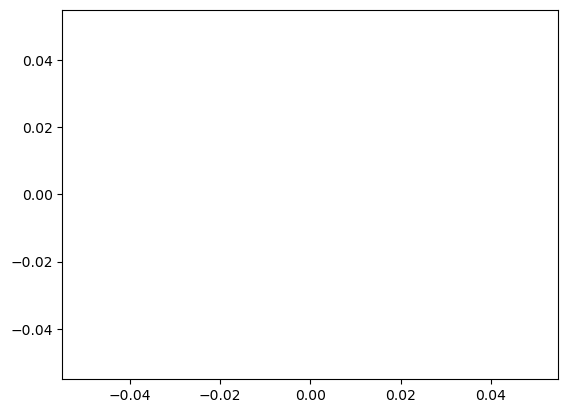

In [27]:
import pandas as pd

# Sample DataFrame with OHLCV data
# Replace this with your actual DataFrame
# Here, we are creating a sample DataFrame for illustration purposes.
data = {
    'Open': [100, 105, 110, 115, 120, 125],
    'High': [102, 107, 112, 117, 122, 127],
    'Low': [98, 103, 108, 113, 118, 123],
    'Close': [101, 106, 111, 116, 121, 126],
    'Volume': [1000, 2000, 3000, 4000, 5000, 6000]
}

index = pd.date_range(start='2023-01-01', periods=6, freq='5T')
df = pd.DataFrame(data, index=index)

# Define the time anchor point (e.g., 10:00 AM)
anchor_time = pd.Timestamp('2023-01-01 10:00:00')

# Calculate the Anchored VWAP
def anchored_vwap(df, anchor_time):
    # Filter the DataFrame for the specified time anchor point
    df_anchor = df[df.index.time == anchor_time.time()]

    # Calculate the anchored VWAP
    anchored_vwap = (df_anchor['Close'] * df_anchor['Volume']).sum() / df_anchor['Volume'].sum()

    return anchored_vwap

# Calculate and print the Anchored VWAP
anchored_vwap_value = anchored_vwap(df, anchor_time)

plt.plot(anchored_vwap_value)
plt.show()
# # Create a candlestick chart with Anchored VWAP
# mpf.plot(df, type='candle', title='Candlestick Chart with Anchored VWAP',
#          addplot=[mpf.make_addplot(anchored_vwap_value, panel=1, color='blue', secondary_y=False)],
#          style='yahoo', volume=True)

# # Show the plot
# plt.show()
